In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askdirectory
from transformers import AutoTokenizer, AutoConfig, GenerationConfig
import os
from pathlib import Path

Tk().withdraw()

''

In [2]:
filename = askopenfilename()

with open (filename, "r") as f:
    dataset = json.load(f)
    
print(dataset[0])

{'instruction': 'Please summarized this line of text', 'input': " Alright, we'll go single file now.", 'clasiifer': 'General Spotting', 'output': ''}


In [3]:
dataset_df = pd.DataFrame()

for index, content in enumerate(dataset):
    content_df = pd.DataFrame([content])
    
    dataset_df = pd.concat([dataset_df , content_df])
    
print(dataset_df.columns)

Index(['instruction', 'input', 'clasiifer', 'output'], dtype='object')


In [28]:
gs_df = dataset_df[dataset_df['clasiifer'] == 'General Spotting']
vh_df = dataset_df[dataset_df['clasiifer'] == 'Vehicle handling']
vs_df = dataset_df[dataset_df['clasiifer'] == 'Vehicle Status']
ps_df = dataset_df[dataset_df['clasiifer'] == 'Pit Strategy']
sr_df = dataset_df[dataset_df['clasiifer'] == 'Spotting Racecraft']
ti_df = dataset_df[dataset_df['clasiifer'] == 'Track Info']
rs_df = dataset_df[dataset_df['clasiifer'] == 'Race Start']

# Randomly sample 200 rows from the filter Dataframe
sample_df = gs_df.sample(n=200 , random_state = 1)

# combine the sameple rows and random select rows
final_df = pd.concat([sample_df , vh_df, vs_df, ps_df, sr_df, ti_df, rs_df])

counts = final_df['clasiifer'].value_counts()
print(counts)

clasiifer
Vehicle handling      219
General Spotting      200
Vehicle Status        172
Pit Strategy          161
Spotting Racecraft    154
Track Info             80
Race Start             29
Name: count, dtype: int64


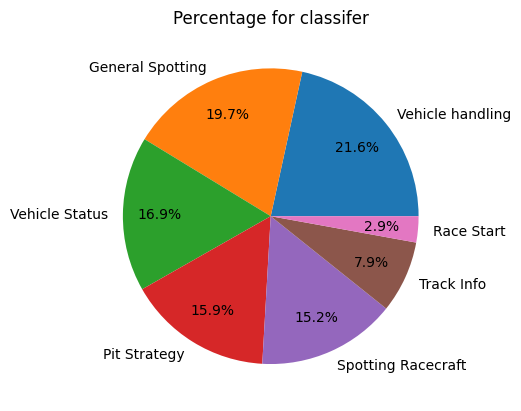

In [29]:
plt.pie(counts, labels = counts.index , autopct='%1.1f%%' , pctdistance=0.75, labeldistance=1.1)
plt.title("Percentage for classifer")
plt.show()

In [30]:
final_df.to_excel("05072024_random200gs_post.xlsx")

In [34]:
final_df.reset_index(inplace = True)
final_df.index

RangeIndex(start=0, stop=1015, step=1)

In [36]:
final_df.columns

Index(['index', 'instruction', 'input', 'clasiifer', 'output'], dtype='object')

In [4]:
# llama3 instruct tokenizer is using the following prompt template for single messages
# messages = [
#    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
#    {"role": "user", "content": "Who are you?"},
#    {"role": "assisant", "content":  "TEXT_GENERATION"}
#]

def llama3_instruct_df_js(main_df):
    # create an empty messages list just to hold all the messages
    messages = []
    
    # for loop to go though all the dataframe
    for index, row in main_df.iterrows():
        
        # create an dict object
        single = []
        
        # here is the part to append system, user and assiant dataset
        sys_message = {}
        sys_message["role"] = 'system'
        sys_message["content"] = 'You are an radio transcript message transcript assisant, please classifer the following message'
        
        # user message 
        user_message = {}
        user_message["role"] = 'user'
        user_message["content"] = row['input']
        
        # assiant message
        assiant_message = {}
        assiant_message["role"] = 'assiant'
        assiant_message["content"] = row['clasiifer']
        
        single.append(sys_message)
        single.append(user_message)
        single.append(assiant_message)
        
        messages.append(single)
        
        
        
    return messages
        
        
        
    

In [38]:
combine = llama3_instruct_df_js(final_df)
combine[10]

[{'role': 'system',
  'content': 'You are an radio transcript message transcript assisant, please classifer the following message'},
 {'role': 'user', 'content': ' Even. Little tighter now.'},
 {'role': 'assiant', 'content': 'General Spotting'}]

In [7]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [42]:
llama_prompt = []

for m in combine:
    prompt = tokenizer.apply_chat_template(
        m,
        tokenize = False
    )
    
    llama_prompt.append(prompt)
    
print(llama_prompt[100])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an radio transcript message transcript assisant, please classifer the following message<|eot_id|><|start_header_id|>user<|end_header_id|>

Alright, everything ready here. Going off Bubba.<|eot_id|><|start_header_id|>assiant<|end_header_id|>

General Spotting<|eot_id|>


In [43]:
with open ("05072024_random200gs_llama3_instruct.json" , 'w') as f:
    json.dump(llama_prompt, f, indent = 3)

In [5]:
raw_combine = llama3_instruct_df_js(dataset_df)

print(raw_combine[10])

raw_llama_prompt = []

for m in raw_combine:
    prompt = tokenizer.apply_chat_template(
        m,
        tokenize = False
    )
    
    raw_llama_prompt.append(prompt)
    
print(len(raw_llama_prompt))

[{'role': 'system', 'content': 'You are an radio transcript message transcript assisant, please classifer the following message'}, {'role': 'user', 'content': ' I got a little bit maybe fast if anything'}, {'role': 'assiant', 'content': 'General Spotting'}]


NameError: name 'tokenizer' is not defined

In [11]:
with open ("05072024_raw_llama3_instruct.json" , 'w') as f:
    json.dump(raw_llama_prompt, f, indent = 3)

In [7]:
raw_combine = llama3_instruct_df_js(dataset_df)

with open('05082024_llama3_merge.json','w') as f:
    json.dump(raw_combine , f, indent = 3)